import nltk
#nltk.download()

#corpora>cmudict
from g2p_en import G2p

texts = ["using g2p"]
g2p = G2p()
for text in texts:
    out = g2p(text)
    print(out)

In [1]:
import os 
import time

import pandas as pd
import math
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import Audio

import torch
import torch.nn.functional as F
import torch.nn as nn
import torchaudio
from torchaudio.functional import spectrogram
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split


2024-06-08 13:32:30.325539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 13:32:30.325632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 13:32:30.460932: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv('/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/metadata.csv',sep = "|",header=None)
df.columns = ["Wav_path","script","n_script"]
df["Wav_path"] = "/kaggle/input/the-lj-speech-dataset/LJSpeech-1.1/wavs/" + df["Wav_path"]

# Sound Transform

In [3]:
sample_rate = 22050
n_fft = 2048
n_stft = int((n_fft//2) + 1)
hop_length = int(n_fft/8.0)
win_length = int(n_fft/2.0)
n_mels = 128
power = 2.0

max_db = 100.0
min_db = 20.0
norm_db = 10.0
ref = 4.0
multiplier = 10.0       
amin = 1e-10            
db_multiplier = 10.0              
scale_db = 10.0
ref_ = 1.0
power_ = 1.0


spec_transform = torchaudio.transforms.Spectrogram(
    n_fft=n_fft, 
    win_length=win_length,
    hop_length=hop_length,
    power=power )


mel_scale_transform = torchaudio.transforms.MelScale(
    n_mels=n_mels, 
    sample_rate=sample_rate, 
    n_stft=n_stft )


inv_mel_transform = torchaudio.transforms.InverseMelScale(
    n_mels=n_mels, 
    sample_rate=sample_rate, 
    n_stft=n_stft ).cuda()


griffnlim_transform = torchaudio.transforms.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length ).cuda()

# normalize a mel spectrogram
def norm_mel_spec(mel_spec):  
    mel_spec = ((2.0*mel_spec - min_db) / (max_db/norm_db)) - 1.0
    mel_spec = torch.clip(mel_spec, -ref*norm_db, ref*norm_db)
    return mel_spec


def denorm_mel_spec(mel_spec):
    mel_spec = (((1.0 + mel_spec) * (max_db/norm_db)) + min_db) / 2.0 
    return mel_spec


def power_to_db_mel_spec(mel_spec):
    mel_spec = torchaudio.functional.amplitude_to_DB(mel_spec,multiplier = multiplier, 
                                                     amin = amin,db_multiplier = db_multiplier, 
                                                     top_db = max_db)
    mel_spec = mel_spec/scale_db
    
    return mel_spec


def db_to_power_mel_spec(mel_spec):
    mel_spec = mel_spec*scale_db
    mel_spec = torchaudio.functional.DB_to_amplitude(mel_spec,ref=ref_,power=power_)  
    return mel_spec


def convert_to_mel_spec(wav):
    spec = spec_transform(wav)
    mel_spec = mel_scale_transform(spec)
    db_mel_spec = power_to_db_mel_spec(mel_spec)
    db_mel_spec = db_mel_spec.squeeze(0)
    
    return db_mel_spec


def inverse_mel_spec_to_wav(mel_spec):
    power_mel_spec = db_to_power_mel_spec(mel_spec)
    spectrogram = inv_mel_transform(power_mel_spec)
    print(spectrogram.shape)
    pseudo_wav = griffnlim_transform(spectrogram)
    return pseudo_wav

In [4]:
wav_path = df['Wav_path'][0] + ".wav"
waveform,sample_rate = torchaudio.load(wav_path, normalize=True)
mel_spec = convert_to_mel_spec(waveform)
print("mel_spec:", mel_spec.shape)

pseudo_wav = inverse_mel_spec_to_wav(mel_spec.cuda())
print("pseudo_wav:", pseudo_wav.shape)

mel_spec: torch.Size([128, 832])
torch.Size([1025, 832])
pseudo_wav: torch.Size([212736])


In [ ]:
spec = spec_transform(waveform)
spec = mel_scale_transform(spec)
spec = power_to_db_mel_spec(spec)
# Plot spectrogram-power
fig, (ax1) = plt.subplots(figsize=(8, 4), ncols=1)

_ = ax1.set_title("Spectrogram power")
pos = ax1.imshow(spec.squeeze(0).detach().cpu().numpy())
_ = fig.colorbar(pos, ax=ax1)

_ = ax1.set_xlabel("Time")
_ = ax1.set_ylabel("Frequency")

In [ ]:
# Original 
Audio(waveform, rate=sample_rate)

In [ ]:
# Inverse
pseudo_wav = inverse_mel_spec_to_wav(mel_spec.cuda())

Audio(pseudo_wav.detach().cpu().numpy(),rate=sample_rate)

In [ ]:
#pseudo_wav.shape

# Process TEXT

In [ ]:
def text_to_tok(text):
    alphabet = {'EOS': 0,
                    ' ': 1,'!': 2,',': 3,'-': 4,'.': 5,';': 6,'?': 7,'a': 8,'b': 9,'c': 10,
                    'd': 11,'e': 12,'f': 13,'g': 14,'h': 15,'i': 16,'j': 17,'k': 18,'l': 19,
                    'm': 20,'n': 21,'o': 22,'p': 23,'q': 24,'r': 25,'s': 26,'t': 27,'u': 28,
                    'v': 29,'w': 30,'x': 31,'y': 32,'z': 33,'à': 34,'â': 35,'è': 36,'é': 37,
                    'ê': 38,'ü': 39,'’': 40,'“': 41,'”': 42}
    text = text.lower()
    liste = []
    for txt in text:
        _id = alphabet.get(txt, None)
        if _id is not None:
            liste.append(_id)
    liste.append(alphabet["EOS"]) 
    return torch.IntTensor(liste)
  
#exp = text_to_tok("Hello")
#print(exp)

In [ ]:
def mask(sequence_lengths,max_length):
    
    ones = sequence_lengths.new_ones(sequence_lengths.size(0), max_length)
    
    range_tensor = ones.cumsum(dim=1)
    
    return sequence_lengths.unsqueeze(1) >= range_tensor 
#print(mask(exp,22))

# DatasetBuilder

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.cache = {}

    def get_item(self, row):
        wav_path = row["Wav_path"]                 
        wav_path = wav_path + ".wav"
        text = row["script"]
        text = text_to_tok(text)
        waveform, sample_rate = torchaudio.load(wav_path, normalize=True)
        mel = convert_to_mel_spec(waveform)
        return (text, mel)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        Wav_path = row["Wav_path"]
        text_mel = self.cache.get(Wav_path)
        
        if text_mel is None:
            text_mel = self.get_item(row)
            self.cache[Wav_path] = text_mel
        return text_mel

    def __len__(self):
        return len(self.df)


In [ ]:

#dataset = CustomDataset(df[0:10])
#dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
#for batch in dataloader:
#    text, mel = batch
#    print("Text sequence:", text)
#    print("Mel spectrogram shape:", mel.shape)


In [ ]:
def collate_fn(batch):
    text_lgt_max = torch.tensor([text.shape[-1] for text, _ in batch],dtype=torch.int32).max()
    
    mel_lgt_max = torch.tensor([mel.shape[-1] for _, mel in batch],dtype=torch.int32).max()
    
    text_lgts_l = []
    mel_lgts_l = []
    text_pads_l = []
    mel_pads_l = []
    
    for text, mel in batch:
        
        text_lgt = text.shape[-1] 
        mel_lgt = mel.shape[-1]
        
        text_pad = torch.nn.functional.pad(text,
                                              pad=[0, text_lgt_max-text_lgt],
                                              value=0)
        
        mel_pad = torch.nn.functional.pad(mel,
                                          pad=[0, mel_lgt_max-mel_lgt],
                                               value=0)
        text_lgts_l.append(text_lgt)    
        mel_lgts_l.append(mel_lgt)    
        text_pads_l.append(text_pad)    
        mel_pads_l.append(mel_pad)
        
    text_lgts_t = torch.tensor(text_lgts_l, dtype=torch.int32)
    mel_lgts_t = torch.tensor(mel_lgts_l, dtype=torch.int32)
    text_pads_t = torch.stack(text_pads_l, 0)
    mel_pads_t = torch.stack(mel_pads_l, 0).transpose(1, 2)
    
    stop_token_pad = mask(mel_lgts_t,mel_lgt_max)
    stop_token_pad = (~stop_token_pad).float()
    stop_token_pad[:, -1] = 1.0
    
    return text_pads_t,text_lgts_t,mel_pads_t,mel_lgts_t,stop_token_pad 

In [ ]:
#data = [
#    (torch.randn(10), torch.randn(128, 50)),  # Text length: 10, Mel length: 50
#    (torch.randn(15), torch.randn(128, 70)),  # Text length: 15, Mel length: 70
#    (torch.randn(12), torch.randn(128, 60)),  # Text length: 12, Mel length: 60
#]
#text_pads_t,text_lgts_t,mel_pads_t,mel_lgts_t,mask_token_pad  = collate_fn(data)

#print("Texts Padded:", text_pads_t)
#print("Text Lengths:", text_lgts_t)
#print("Mel Spectrograms Padded:", mel_pads_t)
#print("Mel Lengths:", mel_lgts_t)
#print("Mask Token Padded:", mask_token_pad)

In [16]:
#dataset = CustomDataset(df[0:5])

#train_loader =DataLoader(
#      dataset, 
#      num_workers=2, 
#      shuffle=True,
#      sampler=None, 
#      batch_size= 1,
#      pin_memory=True, 
#      drop_last=True, 
#      collate_fn=collate_fn
#  )

#def names_shape(names, shape):  
#    return "(" + ", ".join([f"{k}={v}" for k, v in list(zip(names, shape))]) + ")"
#for i, batch in enumerate(train_loader):
#    text_pads_t,text_lgts_t,mel_pads_t,mel_lgts_t,mask_token_pad  = batch
#    print(f"=========batch {i}=========")
#    print("Texts Padded:", names_shape(["N", "S"], text_pads_t.shape))
#    print("Text Lengths::", names_shape(["N"], text_lgts_t.shape))
#    print("Mel Spectrograms Padded:", names_shape(["N", "TIME", "FREQ"], mel_pads_t.shape))
#    print("Mel Lengths:", names_shape(["N"], mel_lgts_t.shape))
#    print("Mask Token Padded:", names_shape(["N", "TIME"], mask_token_pad.shape))

# Transformer Based Model

In [17]:
class EncoderPreNet(nn.Module):
    def __init__(self):
        super(EncoderPreNet, self).__init__()
        
        self.embedding = nn.Embedding(num_embeddings=512,embedding_dim=512)
        
        self.linear1 = nn.Linear(in_features = 512,out_features = 512)
        self.linear2 = nn.Linear(in_features = 512,out_features = 256)
        
        
        self.conv1 = nn.Conv1d(in_channels  = 512,out_channels = 512,kernel_size = 3,
                               stride = 1,padding = 1, dilation = 1)
        self.conv2 = nn.Conv1d(in_channels  = 512,out_channels = 512,kernel_size = 3,
                               stride = 1,padding = 1, dilation = 1)
        self.conv3 = nn.Conv1d(in_channels  = 512,out_channels = 512,kernel_size = 3,
                               stride = 1,padding = 1, dilation = 1)
        
        
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(512)
        
        self.dropout1 = torch.nn.Dropout(0.5)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.dropout3 = torch.nn.Dropout(0.5)    
        
    def forward(self, text):
        
        x = self.embedding(text) # (N, S, E)
        x = self.linear1(x)
        x = x.transpose(2, 1) # (N, E, S) 
            
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
            
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)    
        x = F.relu(x)
        x = self.dropout3(x)

        x = x.transpose(1, 2) # (N, S, E)
        x = self.linear2(x)

        return x


In [18]:
class DecoderPreNet(nn.Module):
    def __init__(self):
        super(DecoderPreNet, self).__init__()
        self.linear1 = nn.Linear(in_features = 128,out_features = 256)
        self.linear2 = nn.Linear(in_features = 256,out_features = 256)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=True)
        
        x = self.linear2(x)
        x = F.relu(x)    
        x = F.dropout(x, p=0.5, training=True)
        
        return x  

In [19]:
class PostNet(nn.Module):
    def __init__(self):
        super(PostNet, self).__init__()  
        
        self.conv1 = nn.Conv1d(in_channels = 128 ,out_channels = 1024,
                                kernel_size=3,stride=1,padding=1, dilation=1)
        self.conv2 = nn.Conv1d(in_channels = 1024 ,out_channels = 1024,
                                kernel_size=3,stride=1,padding=1,dilation=1)
        self.conv3 = nn.Conv1d(in_channels = 1024 ,out_channels = 1024,
                                kernel_size=3,stride=1,padding=1, dilation=1)
        self.conv4 = nn.Conv1d(in_channels = 1024 ,out_channels = 1024,
                                kernel_size=3,stride=1,padding=1, dilation=1)
        self.conv5 =nn.Conv1d(in_channels = 1024 ,out_channels = 1024,
                                kernel_size=3,stride=1,padding=1, dilation=1)
        self.conv6 = nn.Conv1d(in_channels = 1024 ,out_channels = 128,
                                kernel_size=3,stride=1,padding=1, dilation=1)
        
        
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(1024)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.bn6 = nn.BatchNorm1d(128)
        
        
        self.dropout1 = torch.nn.Dropout(0.5)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.dropout4 = torch.nn.Dropout(0.5)
        self.dropout5 = torch.nn.Dropout(0.5)
        self.dropout6 = torch.nn.Dropout(0.5)
        
    def forward(self, x):
        
        # x - (N, TIME, FREQ)

        x = x.transpose(2, 1) # (N, FREQ, TIME)

        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.tanh(x)
        x = self.dropout1(x) # (N, POSNET_DIM, TIME)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.tanh(x)
        x = self.dropout2(x) 

        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.tanh(x)
        x = self.dropout3(x) 

        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.tanh(x)
        x = self.dropout4(x)    

        x = self.conv5(x)
        x = self.bn5(x)
        x = torch.tanh(x)
        x = self.dropout5(x) 

        x = self.conv6(x)
        x = self.bn6(x)
        x = self.dropout6(x) # (N, FREQ, TIME)

        x = x.transpose(1, 2)

        return x

In [20]:
def check_for_nans(tensor, tensor_name):
    if torch.isnan(tensor).any():
        print(f"NaNs found in {tensor_name}")
    if torch.isinf(tensor).any():
        print(f"Infinities found in {tensor_name}")

In [21]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
    
        self.attn = torch.nn.MultiheadAttention(embed_dim = 256,
                                                num_heads=4,
                                                dropout=0.1,
                                                batch_first=True)
        
        self.linear1 = nn.Linear(in_features = 256,out_features = 1024)
        self.linear2 = nn.Linear(in_features = 1024,out_features = 256)
        
        self.norm1 = nn.LayerNorm(normalized_shape = 256)
        self.norm2 = nn.LayerNorm(normalized_shape = 256)
        
        self.dropout1 = torch.nn.Dropout(0.2)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.dropout3 = torch.nn.Dropout(0.2)
        
    def forward(self,x,attn_mask,key_padding_mask):
        #print('encoder')
        #check_for_nans(x, 'x')
        x_tmp = self.norm1(x)
        #check_for_nans(x_tmp, 'x_tmp_norm')
        x_tmp, _ = self.attn(query=x_tmp,
                             key=x_tmp,
                             value=x_tmp,
                             attn_mask=attn_mask,
                             key_padding_mask=key_padding_mask)
        #check_for_nans(x_tmp, 'x_tmp_att')
            
        x_tmp = self.dropout1(x_tmp)
        #check_for_nans(x_tmp, 'x_tmp_drop')
        x = x + x_tmp    
        #check_for_nans(x, 'x_tmp + x')
        x_tmp = self.norm2(x) 
        #check_for_nans(x_tmp, 'x_tmp_norm2')
        x_tmp = self.linear1(x_tmp)
        #check_for_nans(x_tmp, 'x_tmp_linear')
        x_tmp = F.relu(x_tmp)
        #check_for_nans(x_tmp, 'x_tmp_relu')
            
        x_tmp = self.dropout2(x_tmp)
        #check_for_nans(x_tmp, 'x_tmp_drop2')
        x_tmp = self.linear2(x_tmp)
        #check_for_nans(x_tmp, 'x_tmp_lin2')
        x_tmp = self.dropout3(x_tmp)
        #check_for_nans(x_tmp, 'x_tmp_drop3')
        x = x + x_tmp
        #check_for_nans(x, 'x final')
            
        return x


In [22]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.self_attn = torch.nn.MultiheadAttention(embed_dim=256,
                                                     num_heads=4,
                                                     dropout=0.1,
                                                     batch_first=True)
        
        self.attn = torch.nn.MultiheadAttention(embed_dim=256,
                                                num_heads=4,
                                                dropout=0.1,
                                                batch_first=True) 
        
        self.linear1 = nn.Linear(in_features = 256,out_features = 1024)
        self.linear2 = nn.Linear(in_features = 1024,out_features = 256)
        self.norm1 = nn.LayerNorm(256)
        self.norm2 = nn.LayerNorm(256)
        self.norm3 = nn.LayerNorm(256)
        
        self.dropout1 = torch.nn.Dropout(0.2)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.dropout4 = torch.nn.Dropout(0.2)


    def forward(self,x,memory,x_attn_mask = None,
                x_key_padding_mask = None,memory_attn_mask = None,
                memory_key_padding_mask = None):
        
        x_tmp, _ = self.self_attn(query=x,key=x,value=x,
                                  attn_mask=x_attn_mask,key_padding_mask=x_key_padding_mask)
    
        x_tmp = self.dropout1(x_tmp)
        x = self.norm1(x + x_tmp)
     
        x_tmp, _ = self.attn(query=x,key=memory,value=memory,
                             attn_mask=memory_attn_mask,key_padding_mask=memory_key_padding_mask)
    
        x_tmp = self.dropout2(x_tmp)
        x = self.norm2(x + x_tmp)

        x_tmp = self.linear1(x)
        x_tmp = F.relu(x_tmp)
        x_tmp = self.dropout3(x_tmp)
        x_tmp = self.linear2(x_tmp)
        x_tmp = self.dropout4(x_tmp)
        x = self.norm3(x + x_tmp)

        return x


In [23]:
class TTSLoss(torch.nn.Module):
    
    def __init__(self):
        super(TTSLoss, self).__init__()
        
        self.mse_loss = torch.nn.MSELoss()
        self.bce_loss = torch.nn.BCEWithLogitsLoss()

    def forward(self, 
                mel_postnet_out, 
                mel_out, stop_token_out, 
                mel_target, 
                stop_token_target): 
        
        stop_token_target = stop_token_target.view(-1, 1)

        stop_token_out = stop_token_out.view(-1, 1)
        mel_loss = self.mse_loss(mel_out, mel_target) +self.mse_loss(mel_postnet_out, mel_target)

        stop_token_loss = self.bce_loss(stop_token_out, stop_token_target) 

        return mel_loss + stop_token_loss


In [24]:
class TransformerTTS(nn.Module):
    def __init__(self, device="cuda"):
        super(TransformerTTS, self).__init__()
        
        self.encoder_prenet = EncoderPreNet()
        self.decoder_prenet = DecoderPreNet()
        self.postnet = PostNet()
        
        self.pos_encoding = nn.Embedding(num_embeddings=1024,embedding_dim=256)

        self.encoder1 = Encoder()
        self.encoder2 = Encoder()
        self.encoder3 = Encoder()

        self.decoder1 = Decoder()
        self.decoder2 = Decoder()
        self.decoder3 = Decoder()

        self.linear1 = nn.Linear(in_features = 256,out_features = 128)
        self.linear2 = nn.Linear(in_features = 256,out_features = 1)
        
        self.norm_memory = nn.LayerNorm(256)
        
    def forward(self, text, text_len,mel, mel_len):  
        N = text.shape[0]
        S = text.shape[1]
        TIME = mel.shape[1]
        
        self.src_key_padding_mask = torch.zeros((N, S),device=text.device).masked_fill(~mask(text_len,max_length=S),float("-inf"))
        #self.src_key_padding_mask = ~mask(text_len, max_length=S).to(text.device)
        self.src_mask = torch.zeros((S, S),device=text.device).masked_fill(torch.triu(torch.full((S, S), True,dtype=torch.bool), diagonal=1).to(text.device),float("-inf"))
        #self.src_mask = torch.triu(torch.ones((S, S), device=text.device, dtype=torch.bool), diagonal=1)
        self.tgt_key_padding_mask = torch.zeros((N, TIME),device=mel.device).masked_fill(~mask(mel_len,max_length=TIME),float("-inf"))
        #self.tgt_key_padding_mask = ~mask(mel_len, max_length=TIME).to(mel.device)
        self.tgt_mask = torch.zeros((TIME, TIME),device=mel.device).masked_fill(torch.triu(torch.full((TIME, TIME), True,device=mel.device,dtype=torch.bool),diagonal=1),float("-inf"))
        #self.tgt_mask = torch.triu(torch.ones((TIME, TIME), device=mel.device, dtype=torch.bool), diagonal=1)
        self.memory_mask = torch.zeros((TIME, S),device=mel.device).masked_fill(torch.triu(torch.full((TIME, S), True,device=mel.device,dtype=torch.bool),diagonal=1),float("-inf"))    
        #self.memory_mask = None
        
        #check_for_nans(self.src_key_padding_mask, "self.src_key_padding_mask")
        #check_for_nans(self.src_mask, "self.src_mask")
        #check_for_nans(self.tgt_key_padding_mask, "self.tgt_key_padding_mask")
        #check_for_nans(self.tgt_mask, "self.tgt_mask")
        #check_for_nans(self.memory_mask, "self.memory_mask")

        text_x = self.encoder_prenet(text) # (N, S, E)    
        #check_for_nans(text_x, "text_x_ep")
        pos_codes = self.pos_encoding(torch.arange(1024).to(mel.device)) # (MAX_S_TIME, E)
        
        S = text_x.shape[1]
        text_x = text_x + pos_codes[:S]
        #check_for_nans(text_x, "text_x")
        
        text_x = self.encoder1(text_x, 
                               attn_mask = self.src_mask, 
                               key_padding_mask = self.src_key_padding_mask)
        check_for_nans(text_x, "text_x_e1")
        text_x = self.encoder2(text_x,
                               attn_mask = self.src_mask, 
                               key_padding_mask = self.src_key_padding_mask)  
        #check_for_nans(text_x, "text_x_e2")
        text_x = self.encoder3(text_x,
                               attn_mask = self.src_mask, 
                               key_padding_mask = self.src_key_padding_mask) # (N, S, E)
        #check_for_nans(text_x, "text_x_e3")

        text_x = self.norm_memory(text_x)
        #check_for_nans(text_x, "text_x_m")
        
        mel_x = self.decoder_prenet(mel) # (N, TIME, E)    
        #print(mel_x.shape)
        mel_x = mel_x + pos_codes[:TIME]
        #check_for_nans(mel_x, "mel_x")


        mel_x = self.decoder1(x=mel_x,
                              memory=text_x,
                              x_attn_mask=self.tgt_mask, 
                              x_key_padding_mask=self.tgt_key_padding_mask,
                              memory_attn_mask=self.memory_mask,
                              memory_key_padding_mask=self.src_key_padding_mask)
        #check_for_nans(mel_x, "mel_x_d1")

        mel_x = self.decoder2(x=mel_x,
                              memory=text_x,
                              x_attn_mask=self.tgt_mask, 
                              x_key_padding_mask=self.tgt_key_padding_mask,
                              memory_attn_mask=self.memory_mask,
                              memory_key_padding_mask=self.src_key_padding_mask)
        #check_for_nans(mel_x, "mel_x_d2")

        mel_x = self.decoder3(x=mel_x,
                              memory=text_x,
                              x_attn_mask=self.tgt_mask, 
                              x_key_padding_mask=self.tgt_key_padding_mask,
                              memory_attn_mask=self.memory_mask,
                              memory_key_padding_mask=self.src_key_padding_mask) # (N, TIME, E)
        #check_for_nans(mel_x, "mel_x_d3")

        mel_linear = self.linear1(mel_x) # (N, TIME, FREQ)
        #check_for_nans(mel_linear, "mel_linear")
        mel_postnet = self.postnet(mel_linear) # (N, TIME, FREQ)
        #check_for_nans(mel_postnet, "mel_postnet")
        mel_postnet = mel_linear + mel_postnet # (N, TIME, FREQ)
        #check_for_nans(mel_postnet, "mel_linear + mel_postnet")
        stop_token = self.linear2(mel_x) # (N, TIME, 1)
        #check_for_nans(stop_token, "stop_token")

        bool_mel_mask = self.tgt_key_padding_mask.ne(0).unsqueeze(-1).repeat(1, 1, 128)

        mel_linear = mel_linear.masked_fill(bool_mel_mask,0)
        #check_for_nans(mel_linear, "mel_linear_mask")

        mel_postnet = mel_postnet.masked_fill(bool_mel_mask,0)
        #check_for_nans(mel_postnet, "mel_postnet_mask")

        stop_token = stop_token.masked_fill(bool_mel_mask[:, :, 0].unsqueeze(-1),1e3).squeeze(2)
        #check_for_nans(stop_token, "stop_token_mask")
        return mel_postnet, mel_linear, stop_token 
    
    @torch.no_grad()
    def inference(self, text, max_length=800, stop_token_threshold = 0.5):
        self.eval()    
        self.train(False)
        text_lgt = torch.tensor(text.shape[1]).unsqueeze(0).cuda()
        N = 1
        SOS = torch.zeros((N, 1, 128), device="cuda")

        mel_pad = SOS
        mel_lgt = torch.tensor(1).unsqueeze(0).cuda()
        stop_token_outputs = torch.FloatTensor([]).to(text.device)
        

        for _ in tqdm(range(max_length)):
            
            mel_postnet, mel_linear, stop_token = self(text, 
                                                       text_lgt,
                                                       mel_pad,
                                                       mel_lgt
                                                      )
            
            mel_pad = torch.cat([mel_pad,mel_postnet[:, -1:, :]],dim=1)
            
            if torch.sigmoid(stop_token[:,-1]) > stop_token_threshold:      
                break
            else:
                stop_token_outputs = torch.cat([stop_token_outputs, stop_token[:,-1:]], dim=1)
                mel_lgt = torch.tensor(mel_pad.shape[1]).unsqueeze(0).cuda()
        
        return mel_postnet, stop_token_outputs
    
    
    def batch_process(self,batch):
        text_pad,text_lgts,mel_pad,mel_lgts,stop_token_pad = batch
        
        text_pad = text_pad.cuda()
        text_lgts = text_lgts.cuda()
        mel_pad = mel_pad.cuda()
        stop_token_pad = stop_token_pad.cuda()
        mel_lgts = mel_lgts.cuda()

        N = mel_pad.shape[0]
        SOS = torch.zeros((N, 1, 128), device=mel_pad.device) # Start of sequence
  
        mel_input = torch.cat([SOS, mel_pad[:, :-1, :]],dim=1)  # (N, L, FREQ)

        return text_pad,text_lgts,mel_pad,mel_lgts,mel_input,stop_token_pad
    
    def calculate_test_loss(self, test_loader,criterion):
        loss_mean = 0.0
        self.eval()

        with torch.no_grad():
            
            for i, batch in enumerate(test_loader):
                
                text_pad,text_lgts,mel_pad,mel_lgts,mel_input,stop_token_pad = self.batch_process(batch)

                post_mel_out,mel_out,stop_token_out = self(text_pad,text_lgts,
                                                           mel_input,mel_lgts)
                
                test_loss = criterion(mel_postnet_out=post_mel_out,mel_out=mel_out,
                                      stop_token_out=stop_token_out,mel_target=mel_pad,
                                      stop_token_target=stop_token_pad)

                loss_mean += test_loss.item()

        loss_mean = loss_mean / (i + 1)  
        return loss_mean
    
    def train_model(self,train_loader,
                    test_loader,optimizer,criterion,
                    scaler,logger,
                    train_saved_path,test_saved_path):
        
        best_test_loss_mean = float("inf")
        best_train_loss_mean = float("inf")
        train_loss_mean = 0.0
        epoch = 0
        i = 0

        if os.path.isfile(train_saved_path):  
            state = torch.load(train_saved_path)
            state_model = state["model"]
            state_optimizer = state["optimizer"]
    
            i = state["i"] + 1
            best_test_loss_mean = state.get("test_loss", float("inf"))
            best_train_loss_mean = state.get("train_loss", float("inf"))

            model.load_state_dict(state_model)
            optimizer.load_state_dict(state_optimizer)

            print(f"Continue training with: {i}; test_loss: {np.round(best_test_loss_mean, 5)}; train_loss: {np.round(best_train_loss_mean, 5)}")
        else:
            print("Start from Scratch")
        while True:
            #print(f"epoch : {epoch}")
            for batch in train_loader:
                text_pad,text_lgts,mel_pad,mel_lgts,mel_input,stop_token_pad = self.batch_process(batch)

                self.train(True)
                self.zero_grad()
        
                with torch.autocast(device_type='cuda', dtype=torch.float16):

                    
                    post_mel_out, mel_out, stop_token_out = self(text_pad,text_lgts,mel_input,mel_lgts)        
            
    
                    loss = criterion(mel_postnet_out = post_mel_out,mel_out = mel_out,
                                     stop_token_out = stop_token_out,mel_target = mel_pad,
                                     stop_token_target = stop_token_pad)
                
                #if torch.isnan(loss):
                    #print("NaN loss detected")
                    #continue  
                    
                scaler.scale(loss).backward()      
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()    
                
                train_loss_mean += loss.item()
                
                if i != 0 and i%1000 == 0:
                    train_loss_mean = train_loss_mean / 1000        
                    logger.add_scalar("Loss/train_loss", train_loss_mean, global_step=i)
                    
                    if i%6000 == 0:
                        test_loss_mean = self.calculate_test_loss(test_loader,criterion)
                        logger.add_scalar("Loss/test_loss", test_loss_mean, global_step=epoch)
                        
                        if i % 6000 == 0:
                            is_best_train = train_loss_mean < best_train_loss_mean
                            is_best_test = test_loss_mean < best_test_loss_mean
                            state = {"model": self.state_dict(),
                                     "optimizer": optimizer.state_dict(),
                                     "i":i,"test_loss": test_loss_mean,
                                     "train_loss": train_loss_mean}
                            
                            if is_best_train:
                                print(f"{i}) Save best train")
                                torch.save(state, train_saved_path)
                                best_train_loss_mean = train_loss_mean
                                
                            if is_best_train:
                                print(f"{i}) Save best test")
                                torch.save(state, test_saved_path)
                                best_test_loss_mean = test_loss_mean       
 
                
            
                    print(f"{i}) Train loss: {np.round(train_loss_mean, 5)}")
                    train_loss_mean = 0.0
                i += 1
            epoch += 1

    

In [25]:
#def test_inference():
#    model = TransformerTTS().cuda()
#    text = text_to_tok("Hello, world.").unsqueeze(0).cuda()
#    mel_postnet, stop_token = model.inference(text, stop_token_threshold=1e3)
#    print("mel_postnet:", mel_postnet.shape)
#    print("stop_token:", stop_token.shape)

#test_inference()

In [26]:
train_df, test_df = train_test_split(df, test_size=64, random_state=42)
  
train_loader = torch.utils.data.DataLoader(CustomDataset(train_df), 
                                           num_workers=2, 
                                           shuffle=True,
                                           sampler=None, 
                                           batch_size=32,
                                           pin_memory=True, 
                                           drop_last=True, 
                                           collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(CustomDataset(test_df), 
                                          num_workers=2, 
                                          shuffle=True,
                                          sampler=None, 
                                          batch_size=8,
                                          pin_memory=True, 
                                          drop_last=True, 
                                          collate_fn=collate_fn)  
  
train_saved_path = "/kaggle/working/train_TransfromerTTS.pt"
test_saved_path = "/kaggle/working/test_TransfromerTTS.pt"
log_path = "/kaggle/working/train_logs"
#print("train_saved_path:", train_saved_path)


#num_epochs = 10
logger = SummaryWriter(log_path)  
criterion = TTSLoss().cuda()
model = TransformerTTS().cuda()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  

In [1]:
model.train_model(train_loader, test_loader,optimizer,criterion, scaler, logger,train_saved_path,test_saved_path)

In [111]:
train_saved_path = "/kaggle/working/train_TransfromerTTS.pt"
state = torch.load(train_saved_path)
model = TransformerTTS().cuda()
model.load_state_dict(state["model"])

text = "Hell."
name_file = "hello_world.mp3"


postnet_mel, gate = model.inference(
  text_to_tok(text).unsqueeze(0).cuda(),
  stop_token_threshold=0.0005
)

100%|██████████| 800/800 [00:08<00:00, 90.00it/s] 


In [112]:
#postnet_mel[0].shape

torch.Size([1025, 800])


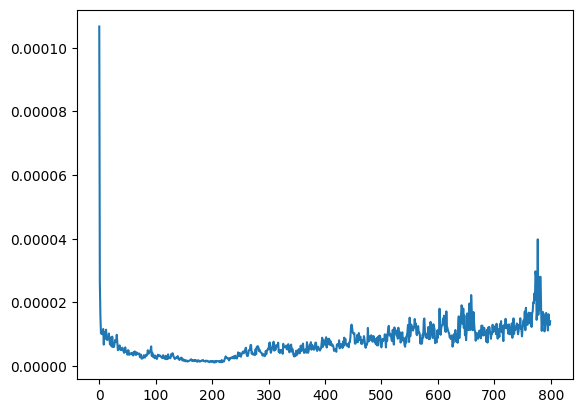

In [113]:
if postnet_mel.numel() > 0:
    audio = inverse_mel_spec_to_wav(postnet_mel[0].T)
    plt.plot(torch.sigmoid(gate[0, :]).detach().cpu().numpy())
else:
    print("Error: Postnet mel is empty")

In [114]:
import pydub

def write_mp3(x, f="audio.mp3",sr=sample_rate, normalized=True):
    """numpy array to MP3"""
    
    if (x.ndim == 2 and x.shape[1] == 2):
        channels = 2  
    else:
        channels = 1
    
    if normalized:  # normalized array - each item should be a float in [-1, 1)
        y = np.int16(x * 2 ** 15)
    else:
        y = np.int16(x)
    song = pydub.AudioSegment(y.tobytes(), frame_rate=sample_rate, sample_width=2, channels=channels)
    song.export(f, format="mp3", bitrate="320k")

In [115]:
write_mp3(audio.detach().cpu().numpy(),name_file)

In [116]:
Audio(audio.detach().cpu().numpy(),rate=sample_rate)